In [84]:
import numpy as np
import scipy.signal as signal
%matplotlib notebook
import matplotlib.pyplot as plt

# Exciting Nonlinearity

I noticed an interesting nonlinearity the other day while analyzing the circuits for Aphex Type B Aural Exciter. This thing has a few pretty nifty circuit, and I particularly wanted to shed some light on the nonlinear procesing that the circuit uses to "generate" higher harmonics.

DISCLAIMER: I was unable to find a service manual, or any other "official" circuit schematic. I have been working from a schematic made by a hobbyist that I found online, and I have no way to verify its accuracy. That said, regardless of whether or not these circuits are actually present in the Aphex Aural Exciter, they're still pretty neat circuits.

To avoid going into more circuit theory than necessary, I'm going to draw a sort of "grey box" diagram, that outlines the overall functions of different parts of the circuit without getting too involved in the details.

In [ ]:
# @TODO: Draw Schematic

Now let's break up this signal flow into its parts.

### Rectifier

The rectifier is a sort of half wave rectifier. You have some choices as to how you may want to implement this. Most of the time, the ideal half-wave rectifier equation should be fine:

$$ f_{rect}(x) = \begin{cases}
                 x & x > 0 \\
                 0 & x \leq 0
                 \end{cases}$$

However, if you want to get a little bit more fancy, or want something a bit more "analog", you could also use the ideal Shockley diode equation (since the rectifier is implemented with a diode in the actual circuit). However, since the diode function blows up for large input, I recommend scaling yourr input by something small (I usually use 0.05).

$$ f_{diode}(x) = 0.2 \left( e^{x/0.0259} - 1 \right) $$

<IPython.core.display.Javascript object>


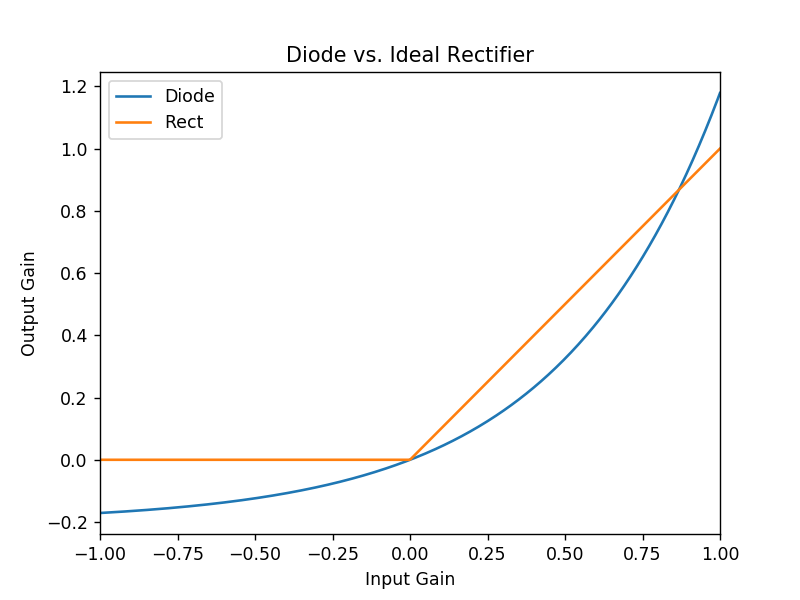

Text(0.5, 1.0, 'Diode vs. Ideal Rectifier')

In [112]:
def rect (x):
    return (x if x > 0 else 0)

def rectBlock (x):
    for n in range (len (x)):
        x[n] = rect (x[n])
    return x

def diode (x):
    return 0.2 * (np.exp (0.05*x/0.0259) - 1)

x = np.linspace (-1, 1, 500)
n = np.linspace (-1, 1, 500)
plt.figure()
plt.plot (n, diode (n))
plt.plot (n, rectBlock (x))
plt.xlim (-1, 1)
plt.xlabel ('Input Gain')
plt.ylabel ('Output Gain')
plt.legend (['Diode', 'Rect'])
plt.title ('Diode vs. Ideal Rectifier')

<IPython.core.display.Javascript object>


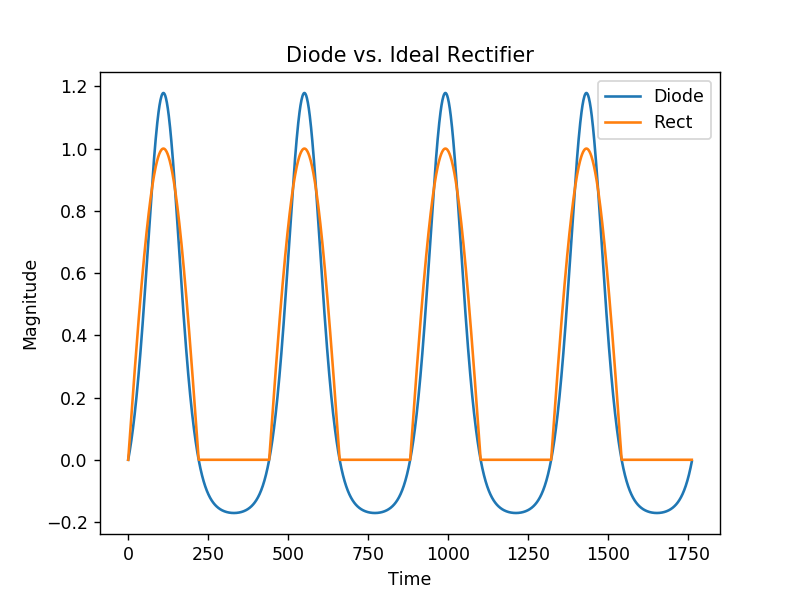

Text(0.5, 1.0, 'Diode vs. Ideal Rectifier')

In [113]:
N = int (44100 / 25)
n = np.arange (N)
x = np.sin (2 * np.pi * n * 100 / 44100)

plt.figure()
plt.plot (diode (x))
plt.plot (rectBlock (x))
plt.xlabel ('Time')
plt.ylabel ('Magnitude')
plt.legend (['Diode', 'Rect'])
plt.title ('Diode vs. Ideal Rectifier')

### Limiter Driver

Despite it's name, the Limiter Driver doesn't really "Drive" the signal, in the traditional sense of adding gain. Instead, its main function is to smooth the output of the rectifier. This is useful, because we're eventually going to be multiplying the whole signal by the output if the driver, so it's important to make sure the output is very low frequency so we don't get a lot of weird artifacts.

<IPython.core.display.Javascript object>


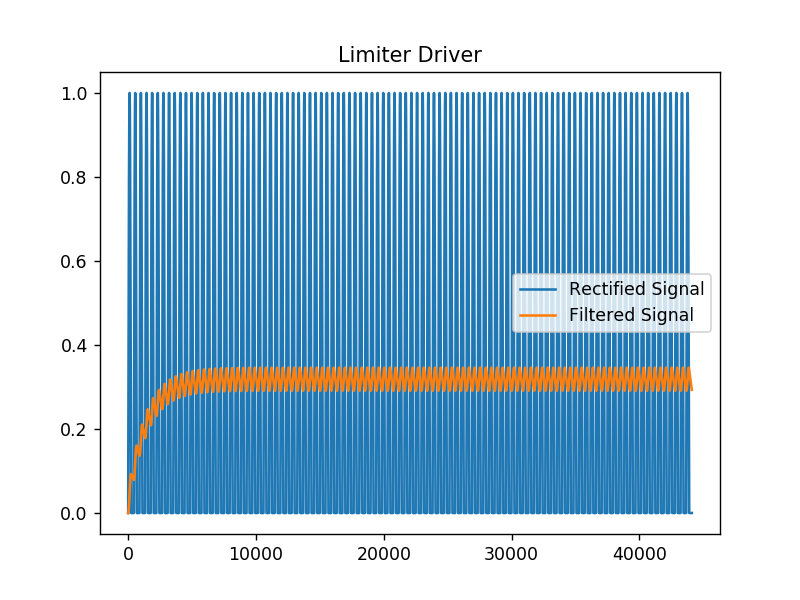

Text(0.5, 1.0, 'Limiter Driver')

In [119]:
N = int (44100)
n = np.arange (N)
x = np.sin (2 * np.pi * n * 100 / 44100)
T = 1/44100
w0 = 2 * np.pi * 5
a0 = c / w0 + 1
a1 = (-c / w0 + 1) / a0
b0 = 1 / a0
b1 = 1 / a0
a0 = 1

z_1 = 0
def filt (x, z_1):
    y = z_1 + x * b0
    z_1 = x * b1 - y * a1
    return y, z_1

y = np.zeros (len (x))
rect_signal = np.zeros (len (x))
for n in range (len (x)):
    x_abs = rect (x[n])
    x_filt, z_1 = filt (x_abs, z_1)
    rect_signal[n] = x_abs
    y[n] = x_filt

plt.figure()
plt.plot (rect_signal)
plt.plot (y)
plt.legend (['Rectified Signal', 'Filtered Signal'])
plt.title ('Limiter Driver')

### Generator

In the diagram above I drew the generator circuit as putting the original input through a sigmoid-type nonlinearity, and then multiplying the signal by the output of the Limiter Driver. The technically inclined reader might ask: how does an analog circuit implement this? The answer is that it uses an OTA (Operational Transconducting Amplifier). When connected in a certain configuration and operating under ideal conditions, the OTA gives the response:

$$ V_{OTA} = I_{abc} \tanh (V_{in} / 0.0259 / 2) $$

where $V_{in}$ is the input voltage, and $I_{abc}$ is the current coming from the limiter driver.

Now let's take a look at the whole system in action. One thing that you'll notice quickly from messing with this nonlinearity is that it's response is very dependent on the input level.

In [132]:
def exciter (x, lpfFreq=4, controlGain=100, fs=44100, rect=np.abs):
    T = 1/fs
    w0 = 2 * np.pi * lpfFreq
    a0 = c / w0 + 1
    a1 = (-c / w0 + 1) / a0
    b0 = 1 / a0
    b1 = 1 / a0
    a0 = 1
    
    z_1 = 0
    def filt (x, z_1):
        y = z_1 + x * b0
        z_1 = x * b1 - y * a1
        return y, z_1
    
    y = np.zeros (len (x))
    for n in range (len (x)):
        x_abs = rect (x[n])
        x_filt, z_1 = filt (x_abs, z_1)
        y[n] = (controlGain * x_filt) * np.tanh (x[n] / 0.0259 / 2)
    
    return y

<IPython.core.display.Javascript object>


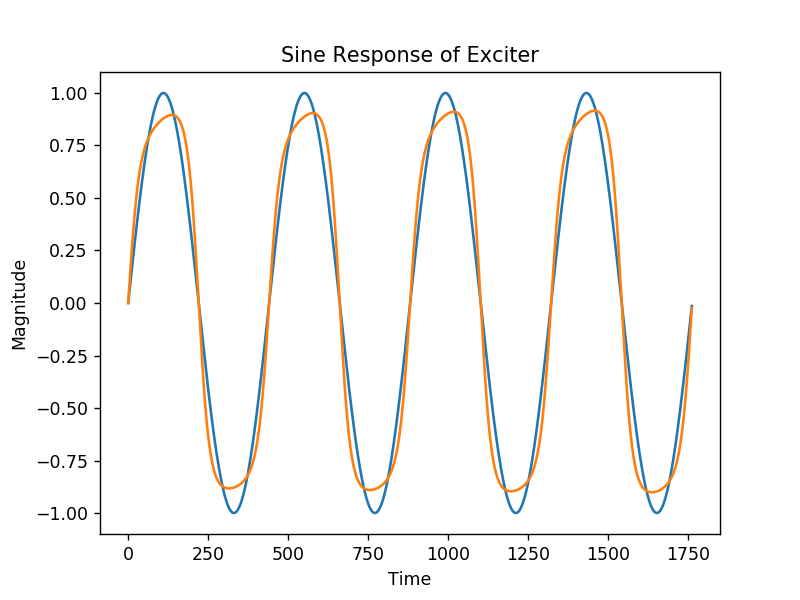

Text(0.5, 1.0, 'Sine Response of Exciter')

In [158]:
def plotExciter (xGain = 0.1, controlGain=30, seconds=1):
    fs = 44100
    N = int (44100*seconds)
    n = np.arange (N)
    x = np.sin (2 * np.pi * n * 100 / fs)
    y = exciter (x*xGain, fs=fs, rect=rect, controlGain=controlGain)
    
    x_test = x[int(3*44100/25):int(4*44100/25)]
    y_test = y[int(3*44100/25):int(4*44100/25)]
    
    return x_test, y_test

x, y = plotExciter()
plt.figure()
plt.plot (x)
plt.plot (y)
plt.xlabel ('Time')
plt.ylabel ('Magnitude')
plt.title ('Sine Response of Exciter')

<IPython.core.display.Javascript object>


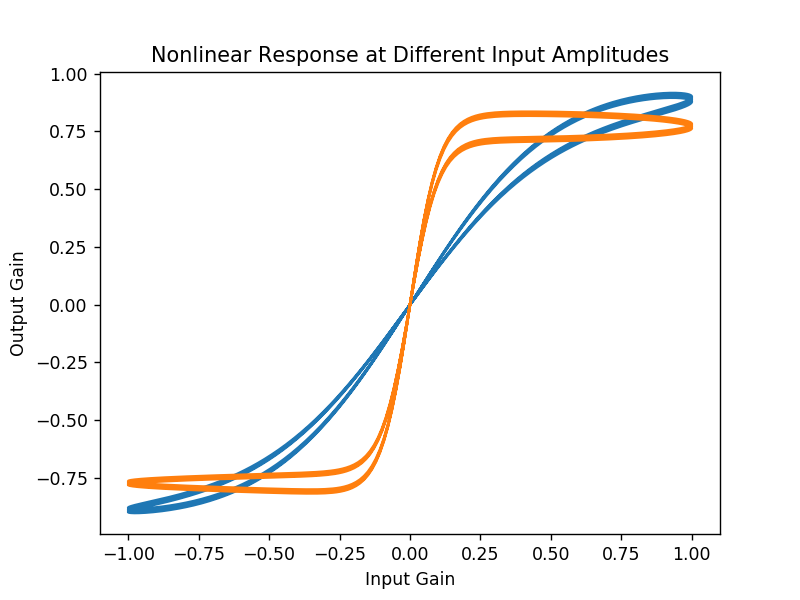

Text(0.5, 1.0, 'Nonlinear Response at Different Input Amplitudes')

In [148]:
plt.figure()

gains = [0.1, 0.5]
controls = [30, 5]

for n in range (len (gains)):
    x, y = plotExciter (xGain=gains[n], controlGain=controls[n])
    plt.plot (x, y)
plt.xlabel ('Input Gain')
plt.ylabel ('Output Gain')
plt.title ('Nonlinear Response at Different Input Amplitudes')

## Frequency Characteristics

One thing you may notice about this nonlinearity is that the response is somewhat asymmetric, which gives it a lot of rich-sounding even harmonics.

<IPython.core.display.Javascript object>


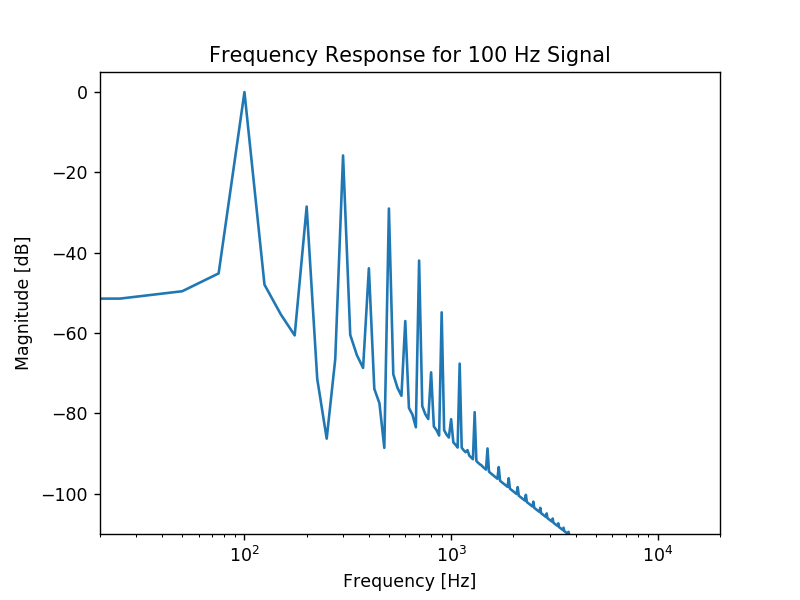

Text(0, 0.5, 'Magnitude [dB]')

In [171]:
x, y = plotExciter(xGain = 0.1, controlGain=100, seconds=4)
N = len (y)

Y = np.fft.rfft (y)
Y = Y / np.max (np.abs (Y))
f = np.linspace (0, 44100/2, int(N/2+1))

plt.figure()
plt.semilogx (f, 20*np.log10 (np.abs (Y)))
plt.xlim (20, 20000)
plt.ylim (-110, 5)
plt.title ('Frequency Response for 100 Hz Signal')
plt.xlabel ('Frequency [Hz]')
plt.ylabel ('Magnitude [dB]')

You may also notice the potential for aliasing, given the appearance of signal above 10x the base frequency. There are a few potential ways for dealing with aliasing. Simply oversampling, perhaps by 8x, will give a pretty good results, removing most aliasing artifacts down to ~-55 dB. Another option would be to do something like antiderivative antialiasing for the sigmoid nonlinearity, as I discussed briefly in my last post. Keep in mind that antiderivative antialiasing adds a half sample delay to the signal, though I doubt this will be a problem for the overall system.